# Librerías

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transform
import torch.nn.functional as F
import seaborn as sns

import matplotlib.pyplot as plt
import numpy as np
import math
import pandas as pd
import sys
import json
import os
import random
import time

from urllib.request import Request, urlopen, urlretrieve
from typing import List
from pprint import pprint
from PIL import Image
from typing_extensions import Required
from torchvision import transforms
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader, Dataset
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix

# Extracción de datos con web scrapping


In [2]:
# son 905, pero los últimos no tienen data
max_pokemon: int = 898

In [3]:
dir1: str = "official-artwork"
if os.path.exists(dir1) == False:
    os.mkdir(dir1)

In [4]:
""" 
SOLO PARA DESCARGAR DATOS
"""
# for pokemon_id in range(max_pokemon):
#     req: Request = Request("https://pokeapi.co/api/v2/pokemon/"+str(pokemon_id+1), 
#                     headers={'User-Agent': 'Mozilla/5.0'})
#     webpage: bytes = urlopen(req).read()
#     json_obj: dict = json.loads(webpage)
#     img_url: str = json_obj["sprites"]["other"]["official-artwork"]["front_default"]
    
#     name: str = json_obj["species"]["name"]
#     type: str = json_obj["types"][0]["type"]["name"]

#     if os.path.exists(dir1+"/"+type) == False:
#         os.mkdir(dir1+"/"+type)
    
#     img: str = img_url.split("/")[-1]
#     urlretrieve(img_url, dir1+"/"+type+"/"+name+".png")

' \nSOLO PARA DESCARGAR DATOS\n'

In [5]:
# Distribución de los datos
types: List[str] = os.listdir(dir1)
for type in types:
    print(type, len(os.listdir(dir1+"/"+type)))
# types.remove("flying")
types = ["grass", "fire", "water", "electric"]
print(types)


bug 75
dark 36
dragon 31
electric 49
fairy 21
fighting 36
fire 58
flying 7
ghost 31
grass 86
ground 35
ice 28
normal 109
poison 35
psychic 58
rock 50
steel 30
water 123
['grass', 'fire', 'water', 'electric']


# CNN

## Alexnet

In [6]:
model = torchvision.models.alexnet(pretrained=True)
for e  in model.parameters():
   e.requires_grad = False
model.classifier[4] = nn.Linear(4096, 1024)
model.classifier[6] = nn.Linear(1024, len(types))
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model.to(device)
print(model)

c:\Users\Diego\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
c:\Users\Diego\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [7]:
x: List[str] = []
y: List[str] = []
for type in types:
    pokemon_imgs: List[str] = os.listdir(dir1+"/"+type)
    for pokemon_img in pokemon_imgs:
        x.append(dir1+"/"+type+"/"+pokemon_img)
        y.append(type)

In [8]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, stratify=y)

In [9]:
class MyDataset(Dataset):
      def __init__(self, list_IDs, labels):
            self.labels = labels
            self.list_IDs = list_IDs

      def __len__(self):
            return len(self.list_IDs)

      def __getitem__(self, index):
            # Select sample
            ID = self.list_IDs[index]

            # Load data and get label
            input_image = Image.open(ID)
            input_image = input_image.convert('RGB')
            preprocess = transforms.Compose([
                  transforms.Resize(256),
                  transforms.CenterCrop(224),
                  transforms.ToTensor()
            ])
            X = preprocess(input_image)
            y = self.labels[index]
            return X, y

In [10]:
le = preprocessing.LabelEncoder()
tensor_y_train = le.fit_transform(y_train)
tensor_y_train = torch.as_tensor(tensor_y_train)
tensor_y_test = le.fit_transform(y_test)
tensor_y_test = torch.as_tensor(tensor_y_test)

In [11]:
batch_size = 64
data_train = MyDataset(x_train, tensor_y_train)
data_test = MyDataset(x_test, tensor_y_test)
train_loader = DataLoader(dataset=data_train, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=data_test, batch_size=batch_size, shuffle=False)

In [12]:
types_freq: dict = {}
for i in y_test:
    if i not in types_freq.keys():
        types_freq[i] = 0
    types_freq[i] += 1
types_freq = dict(sorted(types_freq.items(), key=lambda kv: kv[1]))
types_freq

{'electric': 15, 'fire': 17, 'grass': 26, 'water': 37}

In [13]:
loss_fn = nn.CrossEntropyLoss()
# optimizer = optim.Adam(model.parameters(), lr=0.001)
optimizer = optim.SGD(model.parameters(), lr=0.005, weight_decay=0.005, momentum=0.9)
# optimizer = optim.SGD(model.parameters(), lr=0.005)
total_step = len(train_loader)
num_epochs = 100

In [14]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [15]:
def train(model, optimizer, loss_fn, num_epochs) -> List[float]:
  # train the model
  total_step: int = len(train_loader)
  print(total_step)

  list_loss: List[float] = []

  beg = time.time()
  for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
      images = images.to(device)
      labels = labels.to(device)
      # forward 
      output = model(images)
      loss   = loss_fn(output, labels)
      # change the params
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
              
      # if (i+1) % 100 == 0:
        # print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
        #       .format(epoch+1, num_epochs, i+1, total_step, loss.item()))
    list_loss.append(loss.item())
    print ('Epoch [{}/{}], Loss: {:.4f}' 
          .format(epoch+1, num_epochs, loss.item()))
  end = time.time()
  print('Finished training trainset in {} seconds'.format(round(end-beg, 2)))

  return list_loss

In [16]:
def test(model):
    with torch.no_grad():
        correct: int = 0
        total: int = 0
        all_predicted: list = []
        all_labels: list = []
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            all_predicted.extend((predicted).tolist())
            all_labels.extend((labels).tolist())
        accuracy: float = 100*correct/total
        val = (np.unique(le.inverse_transform(all_predicted)))
        matrix = confusion_matrix(all_labels, all_predicted)
        df = pd.DataFrame(matrix, index=val, columns=val)
        sns.heatmap(df, annot=True, cbar=None, cmap="Greens")
        plt.title("Confusion Matrix"), plt.tight_layout()
        plt.xlabel("Predicted")
        plt.ylabel("Real")
        plt.show()
        print('Test accuracy of the model on the {} test images: {} %'.format(len(data_test), round(accuracy, 2)))


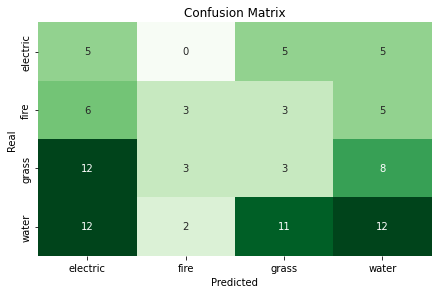

Test accuracy of the model on the 95 test images: 24.21 %


In [17]:
# test before train
test(model)

In [18]:
loss_arr = train(model, optimizer, loss_fn, num_epochs)

4
Epoch [1/100], Loss: 1.9996
Epoch [2/100], Loss: 1.2157
Epoch [3/100], Loss: 0.7567
Epoch [4/100], Loss: 0.5421
Epoch [5/100], Loss: 0.5793
Epoch [6/100], Loss: 0.5973
Epoch [7/100], Loss: 0.6978
Epoch [8/100], Loss: 0.6289
Epoch [9/100], Loss: 0.4619
Epoch [10/100], Loss: 0.6813
Epoch [11/100], Loss: 0.4171
Epoch [12/100], Loss: 0.2719
Epoch [13/100], Loss: 0.3776
Epoch [14/100], Loss: 0.2689
Epoch [15/100], Loss: 0.5126
Epoch [16/100], Loss: 0.4740
Epoch [17/100], Loss: 0.3713
Epoch [18/100], Loss: 0.3467
Epoch [19/100], Loss: 0.3809
Epoch [20/100], Loss: 0.3647
Epoch [21/100], Loss: 0.1770
Epoch [22/100], Loss: 0.2521
Epoch [23/100], Loss: 0.2663
Epoch [24/100], Loss: 0.2840
Epoch [25/100], Loss: 0.1461
Epoch [26/100], Loss: 0.2952
Epoch [27/100], Loss: 0.1164
Epoch [28/100], Loss: 0.1996
Epoch [29/100], Loss: 0.1198
Epoch [30/100], Loss: 0.1407
Epoch [31/100], Loss: 0.2696
Epoch [32/100], Loss: 0.5685
Epoch [33/100], Loss: 0.1580
Epoch [34/100], Loss: 0.2022
Epoch [35/100], Loss:

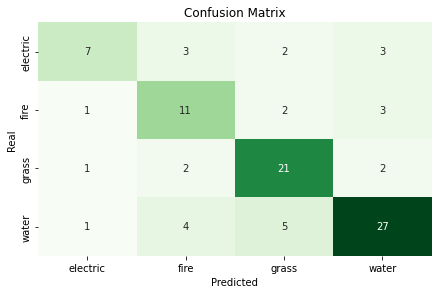

Test accuracy of the model on the 95 test images: 69.47 %


In [28]:
# test after train
torch.manual_seed(1)
test(model)

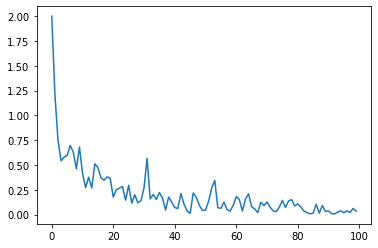

In [21]:
plt.plot(loss_arr)

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=3aacc1cb-5089-4847-a621-d96cb5e11cda' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>